In [1]:
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from os import listdir
from os.path import isfile, join, isdir
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes
import math
from scipy.interpolate import spline
from scipy.interpolate import make_interp_spline, BSpline
from scipy.ndimage.filters import gaussian_filter1d

First of all, we are looking at the positions of air pollutants stations throught Europe


In [2]:
import chardet
RELATIVE_DATA_PATH = './data'

# Load metadata
metadata = pd.read_csv(join(RELATIVE_DATA_PATH, 'metadata.csv'))
metadata.columns


Index(['Countrycode', 'Namespace', 'AirQualityNetwork', 'AirQualityStation',
       'AirQualityStationNatCode', 'AirQualityStationEoICode',
       'AirQualityStationArea', 'SamplingPoint', 'SamplingProcess', 'Sample',
       'BuildingDistance', 'EquivalenceDemonstrated', 'InletHeight',
       'KerbDistance', 'MeasurementEquipment', 'MeasurementType',
       'MeasurementMethod', 'AirPollutantCode', 'AirPollutant',
       'AirQualityStationType', 'Projection', 'Longitude', 'Latitude',
       'Altitude'],
      dtype='object')

In [2]:
# Load data
def loadDataPollutant(countries, pollutant, cols):
    print(f"Loading pollutant: ${pollutant}")
    countries_data = {}
    for country in countries: #countries[:2]:
        frames = []
        print(f"Parsing {country}\n")
        try:
            pollutantsPath = join(RELATIVE_DATA_PATH, country)
            pollutantsPath = pollutantsPath + pollutant
            pollutants = listdir(pollutantsPath)
            
            if not pollutants:
                continue
                
            for dataCSV in pollutants:
                dataCSVPath = join(pollutantsPath, dataCSV)        
                with open(dataCSVPath, 'rb') as f:
                    info = chardet.detect(f.read())
                    currentCSV = pd.read_csv(dataCSVPath, sep=',', usecols=cols, encoding=info.get('encoding'))
    
                    data = pd.DataFrame(currentCSV)
    
                    # Convert data columns
                    try:
                        data.DatetimeBegin = pd.to_datetime(data.DatetimeBegin, utc = True)
                        data.DatetimeEnd = pd.to_datetime(data.DatetimeEnd, utc = True)
                        # Set index
                        data.set_index(['DatetimeBegin'], inplace = True)
                        # Sort by index (by DatetimeBegin)
                        data.sort_index(inplace=True)
                        # Keep only one entry per sensor for each day
                        # data = data.iloc[12::24, :]
                        frames.append(data)
                    except:
                        print("No datetime data")
            countries_data[country] = pd.concat(frames)
        except Exception as e: 
            print(e)
    print('End')
    return countries_data


In [12]:
# Load O3 data for CH, ES, FI and PT
countries = ['AD', 'AL', 'AT', 'BA', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GI',
                 'GR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'LU', 'LV', 'ME', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO',
                 'RS', 'SE', 'SI', 'SK', 'TR']
pollutants = ['/CO/', '/NO2/', '/O3/', '/SO2/', '/Pb/', '/PM2.5/', '/PM10/']
cols = ['Countrycode', 'AirQualityStation', 'Concentration', 'DatetimeBegin', 'DatetimeEnd', 'AirPollutant']

for pollutant in pollutants:
    try:
        currentPollutantData = pd.concat(loadDataPollutant(countries, pollutant, cols).values(), sort=True)
        countries_data = countries_data.append(currentPollutantData, ignore_index=False)
    except Exception as e: 
        print(e)


Loading pollutant: $/CO/
Parsing PT

End
Loading pollutant: $/NO2/
Parsing PT

End
Loading pollutant: $/O3/
Parsing PT

End
Loading pollutant: $/SO2/
Parsing PT

End
Loading pollutant: $/Pb/
Parsing PT

End
No objects to concatenate
Loading pollutant: $/PM2.5/
Parsing PT

End
Loading pollutant: $/PM10/
Parsing PT

End


In [13]:
# Save data to pickle
countries_data.to_pickle("./countried_data_geostory.pkl")


In [3]:
# Load data from pickle
countries_data = pd.read_pickle("./countried_data_geostory.pkl")


In [4]:
# Join with metadata (get Longitude and Latitude)
metadata_subset = metadata[['Latitude', 'Longitude','Countrycode', 'AirQualityStation']]
metadata_subset = metadata_subset[ metadata_subset.Latitude.notna() & metadata_subset.Longitude.notna() ]
spatial_data = pd.merge(countries_data, metadata_subset, how='inner', left_on = ['Countrycode', 'AirQualityStation'], right_on =['Countrycode', 'AirQualityStation'])
spatial_data = spatial_data.drop_duplicates(subset='AirQualityStation', keep="last")
spatial_data.geometry = spatial_data.apply(lambda row: Point(row.Longitude, row.Latitude), axis = 1)
spatial_data.to_pickle("./spatial_data.pkl")

spatial_data.head()


NameError: name 'metadata' is not defined

In [5]:
# Load metadata
spatial_data = pd.read_pickle('./spatial_data.pkl')


In [6]:
# Set filepath
fp = "./L2_data/Europe_borders.shp"

# Read file using gpd.read_file()
europeMap = gpd.read_file(fp)


We can observe that from the countries analyzed Spain has the biggest density of pollutant analyzer stations

AttributeError: 'DataFrame' object has no attribute 'geometry'

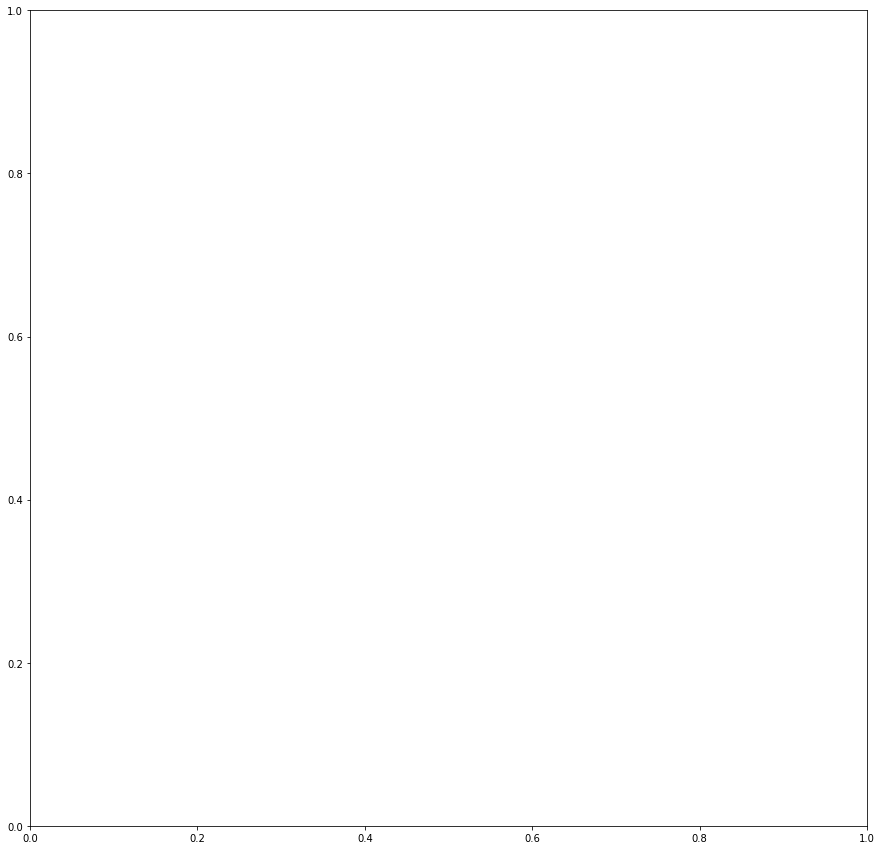

In [7]:
fig, ax = plt.subplots(figsize = (15, 15))
crs = {'init': 'epsg:4326'}
europeMapDs = gpd.GeoDataFrame(spatial_data, crs=crs, geometry=spatial_data.geometry)
europeMap.plot(ax = ax)
europeMapDs.geometry.plot(marker='o', color = 'red', ax = ax, label = 'WNV-', alpha=.5, markersize = 75)


For each country we are going to choose a AirQualityStation and compare the values of their pollutants

stations: ['STA-MT00005' 'STA-MT00007']
country MT, pollutant CO, station STA-MT00005 -> count: 29832
stations: ['STA-MT00004' 'STA-MT00008' 'STA-MT00007' 'STA-MT00005']
country MT, pollutant NO2, station STA-MT00004 -> count: 38143
stations: ['STA-MT00007' 'STA-MT00008' 'STA-MT00004' 'STA-MT00005']
country MT, pollutant O3, station STA-MT00007 -> count: 40785
stations: ['STA-MT00005' 'STA-MT00004' 'STA-MT00007']
country MT, pollutant SO2, station STA-MT00005 -> count: 38143
stations: ['STA-MT00007' 'STA-MT00005' 'STA-MT00004']
country MT, pollutant PM2.5, station STA-MT00007 -> count: 13749
stations: ['STA-MT00007' 'STA-MT00005' 'STA-MT00004']
country MT, pollutant PM10, station STA-MT00007 -> count: 18721


No handles with labels found to put in legend.


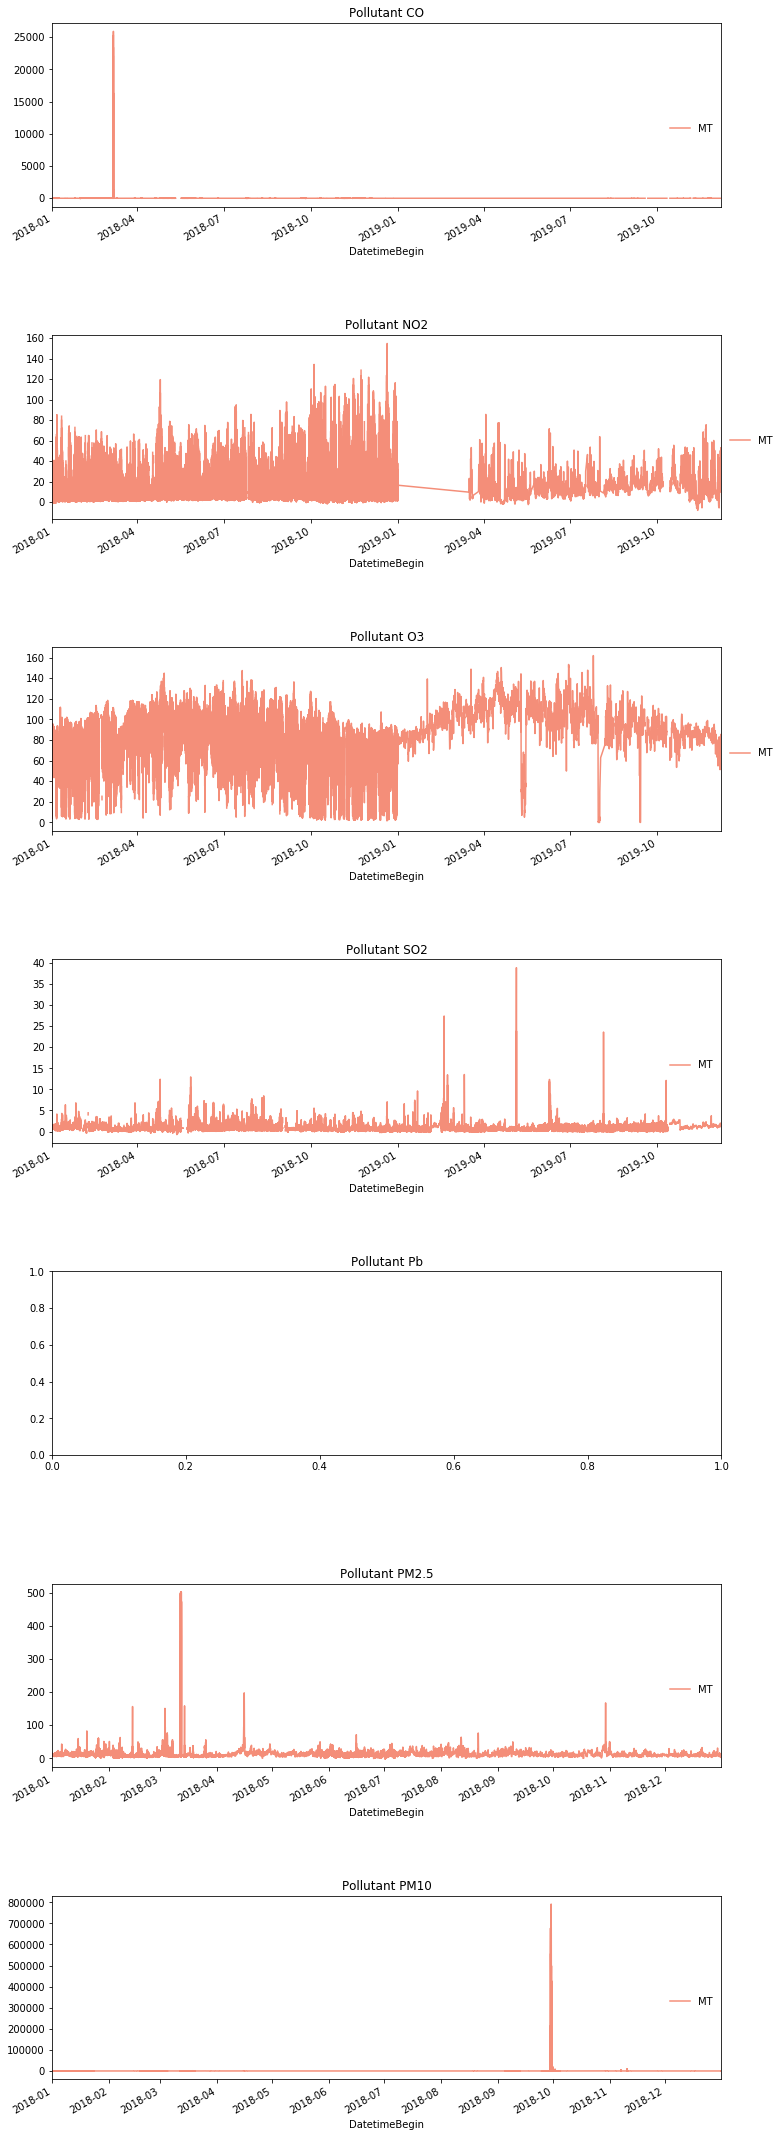

In [27]:
ncols = 1
nrows = len(pollutants)
fig, axes = plt.subplots(nrows=nrows, ncols = ncols, figsize=(12, 6 * nrows))
plt.subplots_adjust(hspace = 0.7)

# For each country, taking by random a certain station
indx = 0
for pollutant in pollutants:
    pollutant = pollutant.split('/')[1]
  
    for country in ['MT']:
        countryData = countries_data[ countries_data.Countrycode == country ]
        countryData = countryData [ countryData.AirPollutant == pollutant ]
        if countryData.Concentration.count() == 0:
            continue
            
        print(f"stations: {countryData.AirQualityStation.unique()}")
        station = countryData.iloc[0].AirQualityStation
        # measurementsForStation = countries_data[ countries_data.AirQualityStation == station ].copy()
        measurementsForStation = countryData.copy()
        print(f"country {country}, pollutant {pollutant}, station {station} -> count: {measurementsForStation.Concentration.count()}")
        
        measurementsForStation['ConcentrationSmooth'] = gaussian_filter1d(measurementsForStation.Concentration, sigma=1)
        measurementsForStation.ConcentrationSmooth.plot(ax = axes[indx], label = country, alpha = 0.7, color=['#f05f40'])

        
    axes[indx].legend( frameon=False,  bbox_to_anchor=(1.0, 0.5))
    axes[indx].title.set_text(f"Pollutant {pollutant}")
    indx += 1


In [18]:
countryData.AirPollutant.describe()

count     18752
unique        1
top        PM10
freq      18752
Name: AirPollutant, dtype: object

We are going to compute a ranking with all the values


In [10]:
countries = ['AD', 'AL', 'AT', 'BA', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GI',
                 'GR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'LU', 'LV', 'ME', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO',
                 'RS', 'SE', 'SI', 'SK', 'TR']
pollutants = ['/CO/', '/NO2/', '/O3/', '/SO2/', '/Pb/', '/PM2.5/', '/PM10/']

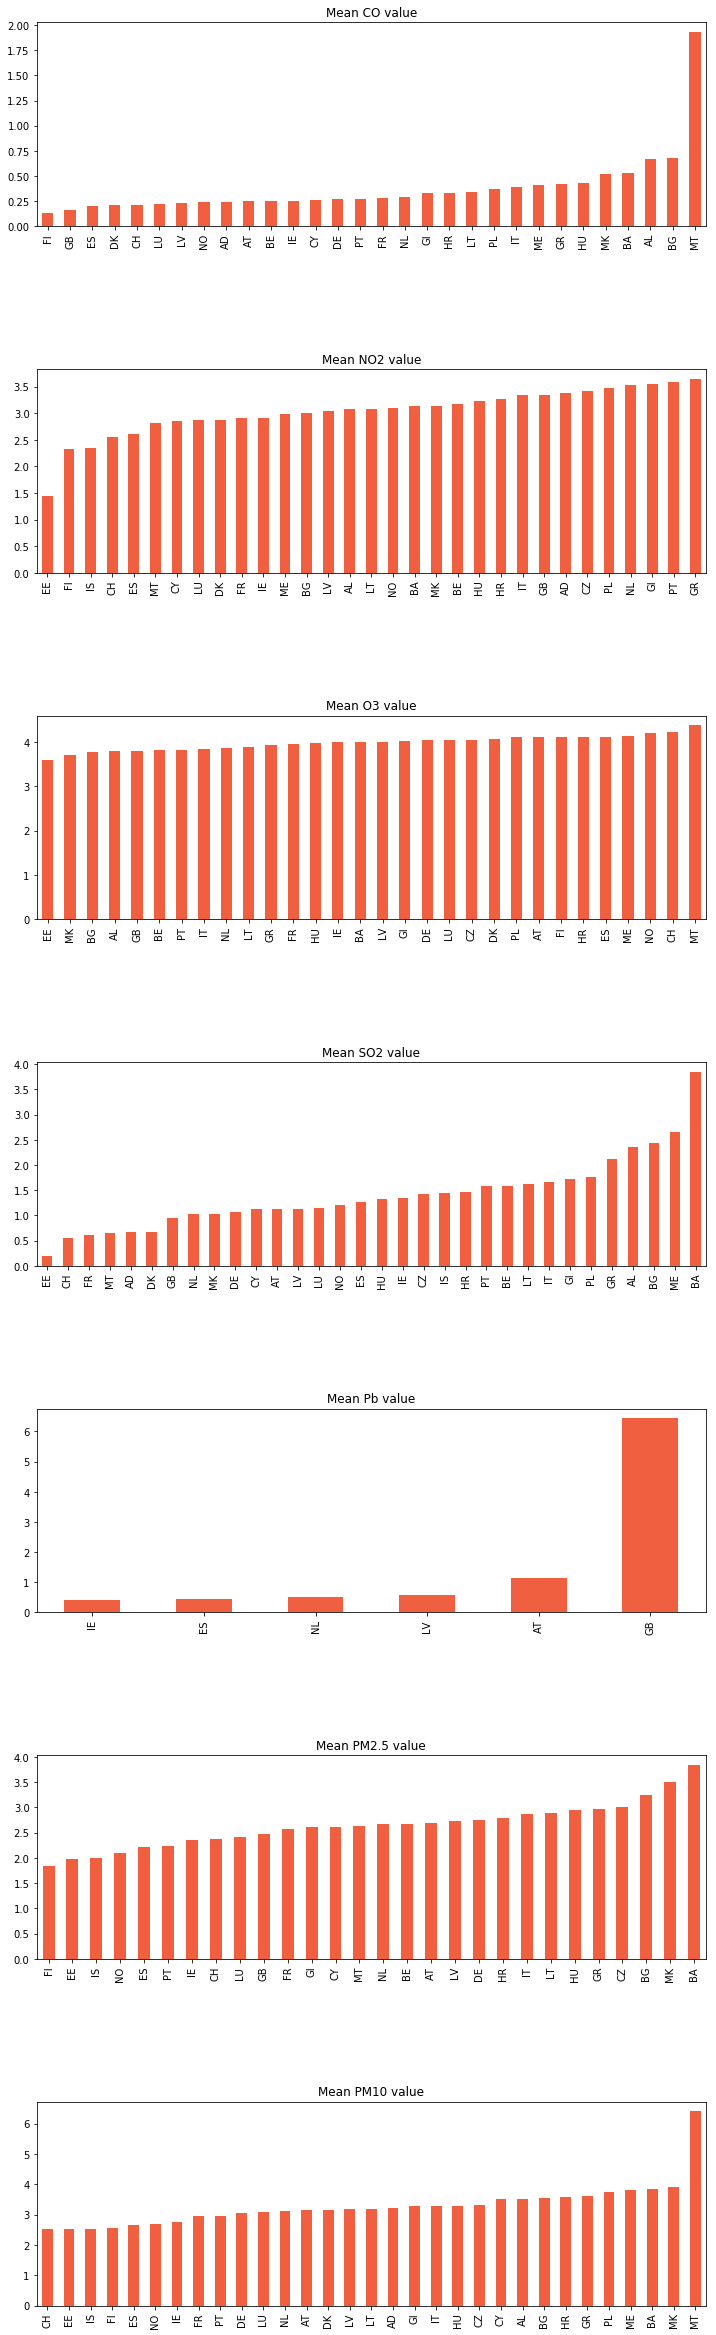

In [11]:
ncols = 1
nrows = len(pollutants)
fig, axes = plt.subplots(nrows=nrows, ncols = ncols, figsize=(12, 6 * nrows))
plt.subplots_adjust(hspace = 0.7)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# For each country, taking by random a certain st
# ation
indx = 0
for pollutant in pollutants:
    pollutant = pollutant.split('/')[1]
    
    packed = []
    i = 0
    for country in countries:
        countryData = countries_data[ (countries_data.Countrycode == country) & (countries_data.AirPollutant == pollutant) ]
        computedMean = countryData.Concentration.mean()
        if math.isnan(computedMean):
            continue
        packed.append( (computedMean, country, colors[0]) )
        i += 1
    packed = sorted(packed, key=lambda x: x[0])
    
    sortedMean = []
    sortedCountry = []
    sortedColors = []
    for val in packed:
        sortedMean.append(val[0])
        sortedCountry.append(val[1])
        sortedColors.append(val[2])
        
    concentrationSeries = np.log(pd.Series(sortedMean) + 1)

    concentrationSeries.plot.bar(ax = axes[indx], color=['#f05f40'])
    
    axes[indx].title.set_text(f"Mean {pollutant} value")
    axes[indx].set_xticklabels(sortedCountry)
    indx += 1


In [58]:
packed

[(nan, 'AD', '#1f77b4'),
 (26.42383266156867, 'MK', '#1f77b4'),
 (29.322805405245408, 'EE', '#1f77b4'),
 (33.61567761031999, 'TR', '#1f77b4'),
 (37.22517184166864, 'BE', '#1f77b4'),
 (39.68378378378379, 'PT', '#1f77b4'),
 (40.499485655503484, 'GR', '#1f77b4'),
 (43.39429988576063, 'AL', '#1f77b4'),
 (43.89826097243582, 'LU', '#1f77b4'),
 (43.95950279821545, 'SI', '#1f77b4'),
 (46.918269628595375, 'GB', '#1f77b4'),
 (47.33902410775762, 'FR', '#1f77b4'),
 (48.88655236391841, 'NL', '#1f77b4'),
 (48.97893776160134, 'RO', '#1f77b4'),
 (49.37487789210629, 'LT', '#1f77b4'),
 (51.10738350860645, 'BG', '#1f77b4'),
 (52.64494077319664, 'FI', '#1f77b4'),
 (53.16885233531009, 'PL', '#1f77b4'),
 (53.26135156003537, 'RS', '#1f77b4'),
 (53.90896332347817, 'SK', '#1f77b4'),
 (53.99587239529397, 'DE', '#1f77b4'),
 (54.76839868532127, 'CZ', '#1f77b4'),
 (55.726706586826346, 'IT', '#1f77b4'),
 (57.2868807386978, 'CH', '#1f77b4'),
 (57.61086271956421, 'LV', '#1f77b4'),
 (58.1906601834712, 'GI', '#1f77b4')